# Simple Bistables

This example shows the key property of a chemical bistable system: it has
two stable states. 
Here we start out with the system settling rather quickly to the first stable
state, where molecule A is high (blue) and the complementary molecule B (green)
is low. At t = 100s, we deliver a perturbation, which is to move 90% of the
A molecules into B. This triggers a state flip, which settles into a distinct
stable state where there is more of B than of A. At t = 200s we reverse the
flip by moving 99% of B molecules back to A. 

If we run the simulation with the gssa option by changing ``"gsl"`` on line 100, 
we see exactly the same sequence of events, except now the switch is noisy.
The calculations are now run with the Gillespie Stochastic Systems Algorithm
(gssa) which incorporates probabilistic reaction events. The switch still
switches but one can see that it might flip spontaneously once in a while.

Things to do:
1. Around line 124 and 129
you will see how the state flip is implemented while maintaining mass
conservation. What happens if you flip over fewer molecules? 
What is the threshold for a successful flip?
Why are these thresholds different for the different states?

2. Try different volumes in line 31, and rerun using the gssa.
Will you see more or less noise if you increase the volume to 1e-20 m^3?


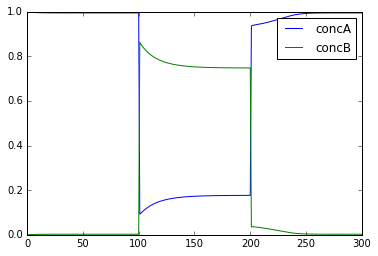

In [1]:
#########################################################################
## This program is part of 'MOOSE', the
## Messaging Object Oriented Simulation Environment.
##           Copyright (C) 2013 Upinder S. Bhalla. and NCBS
## It is made available under the terms of the
## GNU Lesser General Public License version 2.1
## See the file COPYING.LIB for the full notice.
#########################################################################

# This example illustrates how to set up a kinetic solver and kinetic model
# using the scripting interface. Normally this would be done using the
# Shell::doLoadModel command, and normally would be coordinated by the
# SimManager as the base of the entire model.
# This example creates a bistable model having two enzymes and a reaction.
# One of the enzymes is autocatalytic.
# The model is set up to run using deterministic integration.
# If you pass in the argument 'gssa' it will run with the stochastic
# solver instead
# You may also find it interesting to change the volume.

%matplotlib inline

import math
import pylab
import numpy
import moose
import sys

def makeModel():
                # create container for model
                model = moose.Neutral( 'model' )
                compartment = moose.CubeMesh( '/model/compartment' )
                compartment.volume = 1e-21 # m^3
                # the mesh is created automatically by the compartment
                mesh = moose.element( '/model/compartment/mesh' ) 

                # create molecules and reactions
                a = moose.Pool( '/model/compartment/a' )
                b = moose.Pool( '/model/compartment/b' )
                c = moose.Pool( '/model/compartment/c' )
                enz1 = moose.Enz( '/model/compartment/b/enz1' )
                enz2 = moose.Enz( '/model/compartment/c/enz2' )
                cplx1 = moose.Pool( '/model/compartment/b/enz1/cplx' )
                cplx2 = moose.Pool( '/model/compartment/c/enz2/cplx' )
                reac = moose.Reac( '/model/compartment/reac' )

                # connect them up for reactions
                moose.connect( enz1, 'sub', a, 'reac' )
                moose.connect( enz1, 'prd', b, 'reac' )
                moose.connect( enz1, 'enz', b, 'reac' )
                moose.connect( enz1, 'cplx', cplx1, 'reac' )

                moose.connect( enz2, 'sub', b, 'reac' )
                moose.connect( enz2, 'prd', a, 'reac' )
                moose.connect( enz2, 'enz', c, 'reac' )
                moose.connect( enz2, 'cplx', cplx2, 'reac' )

                moose.connect( reac, 'sub', a, 'reac' )
                moose.connect( reac, 'prd', b, 'reac' )

                # connect them up to the compartment for volumes
                #for x in ( a, b, c, cplx1, cplx2 ):
                #                        moose.connect( x, 'mesh', mesh, 'mesh' )

                # Assign parameters
                a.concInit = 1
                b.concInit = 0
                c.concInit = 0.01
                enz1.kcat = 0.4
                enz1.Km = 4
                enz2.kcat = 0.6
                enz2.Km = 0.01
                reac.Kf = 0.001
                reac.Kb = 0.01

                # Create the output tables
                graphs = moose.Neutral( '/model/graphs' )
                outputA = moose.Table ( '/model/graphs/concA' )
                outputB = moose.Table ( '/model/graphs/concB' )

                # connect up the tables
                moose.connect( outputA, 'requestOut', a, 'getConc' );
                moose.connect( outputB, 'requestOut', b, 'getConc' );

                # Schedule the whole lot
                moose.setClock( 4, 0.01 ) # for the computational objects
                moose.setClock( 8, 1.0 ) # for the plots
                # The wildcard uses # for single level, and ## for recursive.
                moose.useClock( 4, '/model/compartment/##', 'process' )
                moose.useClock( 8, '/model/graphs/#', 'process' )

def displayPlots():
                for x in moose.wildcardFind( '/model/graphs/conc#' ):
                                t = numpy.arange( 0, x.vector.size, 1 ) #sec
                                pylab.plot( t, x.vector, label=x.name )
                pylab.legend()
                pylab.show()

def main():
                solver = "gsl"
                makeModel()
                if ( len ( sys.argv ) == 2 ):
                    solver = sys.argv[1]
                stoich = moose.Stoich( '/model/compartment/stoich' )
                stoich.compartment = moose.element( '/model/compartment' )
                if ( solver == 'gssa' ):
                    gsolve = moose.Gsolve( '/model/compartment/ksolve' )
                    stoich.ksolve = gsolve
                else:
                    ksolve = moose.Ksolve( '/model/compartment/ksolve' )
                    stoich.ksolve = ksolve
                stoich.path = "/model/compartment/##"
                #solver.method = "rk5"
                #mesh = moose.element( "/model/compartment/mesh" )
                #moose.connect( mesh, "remesh", solver, "remesh" )
                moose.setClock( 5, 1.0 ) # clock for the solver
                moose.useClock( 5, '/model/compartment/ksolve', 'process' )

                moose.reinit()
                moose.start( 100.0 ) # Run the model for 100 seconds.

                a = moose.element( '/model/compartment/a' )
                b = moose.element( '/model/compartment/b' )

                # move most molecules over to b
                b.conc = b.conc + a.conc * 0.9
                a.conc = a.conc * 0.1
                moose.start( 100.0 ) # Run the model for 100 seconds.

                # move most molecules back to a
                a.conc = a.conc + b.conc * 0.99
                b.conc = b.conc * 0.01
                moose.start( 100.0 ) # Run the model for 100 seconds.

                # Iterate through all plots, dump their contents to data.plot.
                displayPlots()

                quit()

# Run the 'main' if this script is executed standalone.
if __name__ == '__main__':
        main()